# Preparation of the analysis
## Importing the libraries

In [239]:
import pandas as pd
import os
import tarfile
import gzip
import datetime
import plotly.express as px 
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


## Importing the dataset

We first define the path to the dataset.

In [69]:
PATH_BA = '../Data/BeerAdvocate_CSV.tar.gz'
PATH_RB = '../Data/RateBeer_CSV.tar.gz'
folder_BA = tarfile.open(PATH_BA)
folder_RB = tarfile.open(PATH_RB)

We now import the dataset and convert the different .csv files to pandas dataframes. This is done on both BeerAdvocate and RateBeer datasets. For each dataset we obtain four dataframes: one for the reviews, one for the beers, one for the breweries and one for the users.

In [70]:
# Extracting the files for BeerAdvocate
df_beers_BA = pd.read_csv(folder_BA.extractfile(folder_BA.getmember('../Data/BeerAdvocate/beers.csv')))
df_users_BA = pd.read_csv(folder_BA.extractfile(folder_BA.getmember('../Data/BeerAdvocate/users.csv')))
df_reviews_BA = pd.read_csv(folder_BA.extractfile(folder_BA.getmember('../Data/BeerAdvocate/reviews.csv')))
df_breweries_BA = pd.read_csv(folder_BA.extractfile(folder_BA.getmember('../Data/BeerAdvocate/breweries.csv')))

# Extracting the files for RateBeer
df_beers_RB = pd.read_csv(folder_RB.extractfile(folder_RB.getmember('../Data/RateBeer/beers.csv')))
df_users_RB = pd.read_csv(folder_RB.extractfile(folder_RB.getmember('../Data/RateBeer/users.csv')))
df_reviews_RB = pd.read_csv(folder_RB.extractfile(folder_RB.getmember('../Data/RateBeer/reviews.csv')))
df_breweries_RB = pd.read_csv(folder_RB.extractfile(folder_RB.getmember('../Data/RateBeer/breweries.csv')))

## Preprocessing the dataframes

### Adding location information to the dataframes

For the review dataframes of both datasets, we want to add two columns that corresponds to the country of the user and the country of the brewery. We do this by extracting the information from the user and brewery dataframes and merging them with the review dataframe. In the end, we obtain `df_RB` and `df_BA` which have the reviews of RateBeer and BeerAdvocate respectively.

In [71]:
#RateBeer
user_nat_RB=pd.DataFrame()
user_nat_RB['user_name']=df_users_RB['user_name']
user_nat_RB['location_user']=df_users_RB['location']
new_reviews_RB=pd.merge(df_reviews_RB, user_nat_RB,  how='inner', on='user_name')

beers_nat_RB=pd.DataFrame()
beers_nat_RB['beer_id']=df_breweries_RB['id']
beers_nat_RB['beers_location']=df_breweries_RB['location']
new_reviews_RB['beer_id']=new_reviews_RB['beer_id'].apply(lambda x: int(x))
df_RB= pd.merge(new_reviews_RB, beers_nat_RB, how='inner', on='beer_id')

#BeerAdvocate
user_nat_BA=pd.DataFrame()
user_nat_BA['user_name']=df_users_BA['user_name']
user_nat_BA['location_user']=df_users_BA['location']
new_reviews_BA=pd.merge(df_reviews_BA, user_nat_BA,  how='inner', on='user_name')

beers_nat_BA=pd.DataFrame()
beers_nat_BA['beer_id']=df_breweries_BA['id']
beers_nat_BA['beers_location']=df_breweries_BA['location']
new_reviews_BA['beer_id']=new_reviews_BA['beer_id'].apply(lambda x: int(x))
df_BA = pd.merge(new_reviews_BA, beers_nat_BA, how='inner', on='beer_id')

#### Adding states for the US based locations

The geographical information contain the name of the country for users and breweries. However, for the US based locations, we also have the name of the state. We want to extract this information and add it to the dataframe. To do so we create will create an extra column for both breweries and users that will contain the US postal abbreviations for each state.

We first extract the postal abbreviations for each state from wikipedia using `pd.read_html`. 

We then process the dataframe into one (`US_states`) containing a column for the postal abbreviations and another one for the corresponding state names. We create from `US_states` two dataframes: `US_states_user` and `US_states_beer`. 

We add the corresponding postal abbreviation to the user and brewery dataframes. We do this by merging the `df_BA` and `df_RB` dataframes with `US_states_user` and `US_states_beer` respectively. 

We then finish processing the locations by dropping the state name in the location column.


In [72]:
# Creating the US_states dataframe
US_states = pd.read_html('https://en.wikipedia.org/wiki/ISO_3166-2:US')[0] 
US_states['Subdivision name (en)'] = US_states['Subdivision name (en)'].apply(lambda x: 'United States, ' + x) 
US_states['Code'] = US_states['Code'].apply(lambda x: x[3:]) 
US_states.drop(columns=['Subdivision category'], inplace=True) 

# Creating the two dataframes from the US_states dataframe
US_states_user=US_states.rename(columns={'Subdivision name (en)':'location_user', 'Code':'US_Code_User'}) 
US_states_beer=US_states.rename(columns={'Subdivision name (en)':'beers_location', 'Code':'US_Code_Beer'}) 

# Merging to add the postal abbreviations to the RateBeer and BeerAdvocate dataframes
df_BA=pd.merge(US_states_beer, df_BA, how='outer', on='beers_location') 
df_BA=pd.merge(US_states_user, df_BA, how='outer', on='location_user') 


df_RB=pd.merge(US_states_beer, df_RB, how='outer', on='beers_location')
df_RB=pd.merge(US_states_user, df_RB, how='outer', on='location_user')

def keep_United_States_if_in_the_string(x): 
    if 'United States' in x: 
        return 'United States' 
    else: 
        return x 

# for the location and nationalities we kept only 'United States' and removed the State name after the comma for ploting.

df_BA['beers_location']=df_BA['beers_location'].apply(lambda x: str(x)) 
df_BA['beers_location']=df_BA['beers_location'].apply(lambda x: keep_United_States_if_in_the_string(x)) 
df_BA['location_user']=df_BA['location_user'].apply(lambda x: str(x)) 
df_BA['location_user']=df_BA['location_user'].apply(lambda x: keep_United_States_if_in_the_string(x)) 

df_RB['beers_location']=df_RB['beers_location'].apply(lambda x: str(x))
df_RB['beers_location']=df_RB['beers_location'].apply(lambda x: keep_United_States_if_in_the_string(x))
df_RB['location_user']=df_RB['location_user'].apply(lambda x: str(x))
df_RB['location_user']=df_RB['location_user'].apply(lambda x: keep_United_States_if_in_the_string(x))


### Exploring where users come from

In order to better define our analysis, we will first explore the geographical distribution of the users. To do so, we will first create a dataframe containing the number of users per country. We will then plot the distribution of the users on a world map. We do this for both dataframes `df_BA` and `df_RB`.

In [73]:
count_country_users_RB=df_RB.groupby('location_user').count()['user_name'].to_frame().reset_index()
count_country_users_RB=count_country_users_RB.rename(columns={'user_name':'count_users'})

fig = px.choropleth(count_country_users_RB, 
                    locations='location_user',  
                    locationmode='country names',  
                    scope="world", 
                    color='count_users', 
                    )
fig.update_layout(title_text='RateBeer - Number of users per country') 
fig.show()

In [74]:
count_country_users_BA=df_BA.groupby('location_user').count()['user_name'].to_frame().reset_index()
count_country_users_BA=count_country_users_BA.rename(columns={'user_name':'count_users'})

fig = px.choropleth(count_country_users_BA, 
                    locations='location_user',  
                    locationmode='country names',  
                    scope="world", 
                    color='count_users',  
                    )
fig.update_layout(title_text='BeerAdvocate - Number of users per country') 
fig.show()

### Focus on the US

We want to focus on the US for our analysis. We therefore create two new dataframes `BA_US` and `RB_US` that contain only the reviews of the US based users.

In [75]:
RB_US = df_RB[df_RB['location_user'] == 'United States']
BA_US = df_BA[df_BA['location_user'] == 'United States']

Let's quickly check if some states have very few reviews.

In [76]:
RB_US['US_Code_User'].value_counts()[RB_US['US_Code_User'].value_counts() < 1000]

HI    831
SD    787
WY    736
DC      1
AS      1
GU      1
MP      1
PR      1
UM      1
VI      1
Name: US_Code_User, dtype: int64

In [77]:
BA_US['US_Code_User'].value_counts()[BA_US['US_Code_User'].value_counts() < 1000]

MT    896
UT    570
ND    456
SD    261
DC      1
AS      1
GU      1
MP      1
PR      1
UM      1
VI      1
Name: US_Code_User, dtype: int64

As we can see the US territories have 1 review each. We will therefore remove them from the dataframe since they will not be useful for our analysis.

In [78]:
RB_US = RB_US[~RB_US['US_Code_User'].isin(['DC', 'AS', 'GU', 'MP', 'PR', 'VI', 'UM'])]
BA_US = BA_US[~BA_US['US_Code_User'].isin(['DC', 'AS', 'GU', 'MP', 'PR', 'VI', 'UM'])]

Let's now explore the distribution of the users in the US. We will plot the distribution of the users on a map of the US.

In [79]:
count_state_users_RB=RB_US.groupby('US_Code_User').count()['user_name'].to_frame().reset_index()
count_state_users_RB=count_state_users_RB.rename(columns={'user_name':'count_users'})

fig = px.choropleth(count_state_users_RB, 
                    locations='US_Code_User',  
                    locationmode='USA-states',  
                    scope="usa", 
                    color='count_users',  
                    )
fig.update_layout(title_text='RateBeer - Number of users per country') 
fig.show()

In [80]:
count_state_users_BA=BA_US.groupby('US_Code_User').count()['user_name'].to_frame().reset_index()
count_state_users_BA=count_state_users_BA.rename(columns={'user_name':'count_users'})

fig = px.choropleth(count_state_users_BA, 
                    locations='US_Code_User',  
                    locationmode='USA-states',  
                    scope="usa", 
                    color='count_users',  
                    )
fig.update_layout(title_text='BeerAdvocate - Number of users per country') 
fig.show()

### Dealing with missing values

We start by checking the number of missing values in each column of the dataframes. 

In [81]:
print(RB_US.isnull().sum())
print("Percentage of NaN values in RB_US: ", (RB_US['text'].isnull().sum()/len(RB_US))*100, "%")

US_Code_User           0
location_user          0
US_Code_Beer      604710
beers_location         0
beer_name              0
beer_id                0
brewery_name           0
brewery_id             0
style                  0
abv                25828
date                   0
user_name              0
user_id                0
appearance             0
aroma                  0
palate                 0
taste                  0
overall                0
rating                 0
text                  44
dtype: int64
Percentage of NaN values in RB_US:  0.005057639852362895 %


In [82]:
print(BA_US.isnull().sum())
print("Percentage of NaN values in BA_US: ", (BA_US['appearance'].isnull().sum()/len(BA_US))*100, "%")

US_Code_User           0
location_user          0
US_Code_Beer      331716
beers_location         0
beer_name              0
beer_id                0
brewery_name           0
brewery_id             0
style                  0
abv                12984
date                   0
user_name              1
user_id                0
appearance          4148
aroma               4148
palate              4148
taste               4148
overall             4148
rating                 0
text                   0
dtype: int64
Percentage of NaN values in BA_US:  0.6316257510834178 %


After our processing, we can see that for `RB_US` we have no NaN values for the rating columns and NaN values for the text column. For `BA_US` we have no NaN values for the text column and NaN values for the rating columns.
If we look at how much these NaN values represent in the dataframes, we can see that for `RB_US` the NaN values represent 0.005% of the data and for `BA_US` the NaN values represent 0.6% of the data. Thus we can drop these rows without losing too much information.

In [83]:
RB_US = RB_US.dropna(subset=['text'], how='all')
BA_US = BA_US.dropna(subset=['appearance','aroma','palate','taste','overall'], how='all')

### Checking data types

In [84]:
RB_US.dtypes

US_Code_User       object
location_user      object
US_Code_Beer       object
beers_location     object
beer_name          object
beer_id           float64
brewery_name       object
brewery_id        float64
style              object
abv               float64
date              float64
user_name          object
user_id           float64
appearance        float64
aroma             float64
palate            float64
taste             float64
overall           float64
rating            float64
text               object
dtype: object

In [85]:
BA_US.dtypes

US_Code_User       object
location_user      object
US_Code_Beer       object
beers_location     object
beer_name          object
beer_id           float64
brewery_name       object
brewery_id        float64
style              object
abv               float64
date              float64
user_name          object
user_id            object
appearance        float64
aroma             float64
palate            float64
taste             float64
overall           float64
rating            float64
text               object
dtype: object

We first have to convert the `date` column to a datetime object. We do this for both `RB_US` and `BA_US`.


In [86]:
RB_US['date'] = RB_US['date'].apply(datetime.datetime.fromtimestamp)
BA_US['date'] = BA_US['date'].apply(datetime.datetime.fromtimestamp)

We finally have our two dataframes `RB_US` and `BA_US` that we will use for the analysis.

## Merging the dataframes

We want to have as much data as possible for our analysis. We therefore need to merge ratings data from both BeerAdvocate and RateBeer. We need to normalize the data because the distributions are different between the two sites. We follow the same procedure as in Lederrey-West paper ([Lederrey-West_WWW-18](https://dlab.epfl.ch/people/west/pub/Lederrey-West_WWW-18.pdf)):
We observe that the mean of the ratings is higher for BeerAdvocate than for Ratebeer. Moreover, when we observe the mean and std of rating over the course of time, *the mean increases, while the standard deviation decreases, from year to year. Assuming that the inherent quality of beers being rated stays roughly constant, the rising mean may be interpreted as score inflation, while the sinking standard deviation could indicate a consolidating consensus about what should constitute the score of an average beer.* (Lederrey-West_WWW-18)

Thus we perform a z-score normalization of the ratings : *for each site and each year, we compute the mean and standard deviation over all ratings.We then subtract the mean of year t from all ratings submitted in year t and divide them by the standard deviation of year t , such that each year’s set of ratings has mean 0 and standard deviation 1.* (Lederrey-West_WWW-18)

Finally we simply merge the two dataframes into one containings all the raitings from both BeerAdvocate and RateBeer with normalized scores for each feature.

In [87]:
def normalize_data(df):
    """
    Normalize the data : compute z scores for each feature (look, smell/aroma, taste, feel/palate, overall & rating)
    we do it for each diffrent year to take the temporal drift of the mean and variance into account
    """
    df['year'] = df['date'].apply(lambda x: x.year)
    for year in df['year'].unique():
        df_year_ = df[df['year'] == year]
        df_year = df_year_.copy()
        for feature in ['appearance','aroma','taste','palate','overall','rating']:
            df_year[feature] = (df_year[feature] - df_year[feature].mean())/df_year[feature].std()
        df.loc[df['year'] == year] = df_year
    return df

In [145]:
# normalize the data
RB_US_norm = normalize_data(RB_US)
BA_US_norm = normalize_data(BA_US)

# merge the two dataframes
df_ratings = pd.concat([RB_US_norm, BA_US_norm], ignore_index=True)

We can observe the distribution of the scores for the different features for normalized BeerAdvocate (blue), RateBeer (red) and merged (white) ratings.

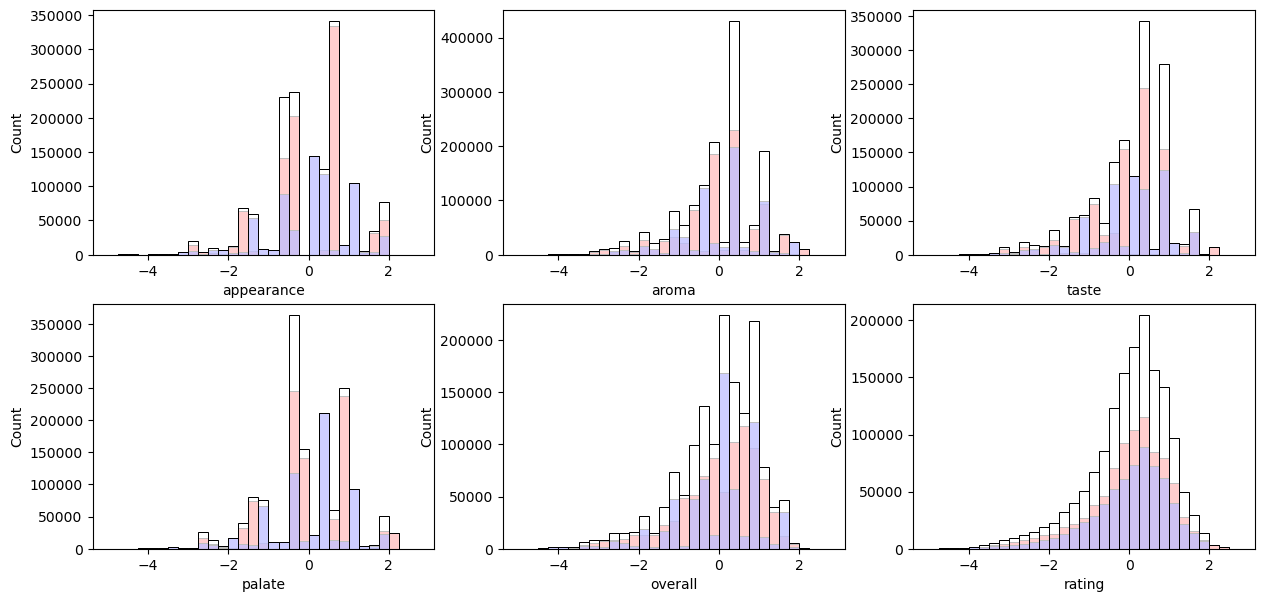

In [89]:
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
sns.histplot(RB_US_norm['appearance'], bins=np.arange(-5, 3, 0.25), ax=ax[0,0], color='red')
sns.histplot(BA_US_norm['appearance'], bins=np.arange(-5, 3, 0.25), ax=ax[0,0], color='blue')
sns.histplot(df_ratings['appearance'], bins=np.arange(-5, 3, 0.25), ax=ax[0,0], color='white')
sns.histplot(RB_US_norm['aroma'], bins=np.arange(-5, 3, 0.25), ax=ax[0,1], color='red')
sns.histplot(BA_US_norm['aroma'], bins=np.arange(-5, 3, 0.25), ax=ax[0,1], color='blue')
sns.histplot(df_ratings['aroma'], bins=np.arange(-5, 3, 0.25), ax=ax[0,1], color='white')
sns.histplot(RB_US_norm['taste'], bins=np.arange(-5, 3, 0.25), ax=ax[0,2], color='red')
sns.histplot(BA_US_norm['taste'], bins=np.arange(-5, 3, 0.25), ax=ax[0,2], color='blue')
sns.histplot(df_ratings['taste'], bins=np.arange(-5, 3, 0.25), ax=ax[0,2], color='white')
sns.histplot(RB_US_norm['palate'], bins=np.arange(-5, 3, 0.25), ax=ax[1,0], color='red')
sns.histplot(BA_US_norm['palate'], bins=np.arange(-5, 3, 0.25), ax=ax[1,0], color='blue')
sns.histplot(df_ratings['palate'], bins=np.arange(-5, 3, 0.25), ax=ax[1,0], color='white')
sns.histplot(RB_US_norm['overall'], bins=np.arange(-5, 3, 0.25), ax=ax[1,1], color='red')
sns.histplot(BA_US_norm['overall'], bins=np.arange(-5, 3, 0.25), ax=ax[1,1], color='blue')
sns.histplot(df_ratings['overall'], bins=np.arange(-5, 3, 0.25), ax=ax[1,1], color='white')
sns.histplot(RB_US_norm['rating'], bins=np.arange(-5, 3, 0.25), ax=ax[1,2], color='red')
sns.histplot(BA_US_norm['rating'], bins=np.arange(-5, 3, 0.25), ax=ax[1,2], color='blue')
sns.histplot(df_ratings['rating'], bins=np.arange(-5, 3, 0.25), ax=ax[1,2], color='white')
plt.show()

# Analysis

## Quick statistics from the data

### Number of reviews per state
blip-blap-bloop

### Number of reviews per beer
bli-blap-bloop

### Number of reviews per brewery
blip-blop-bloop

## 2 - Digging deeper, fine-tuning our analysis
### 2.1 - PCA on the rating aspects

First we load the necessary dataframes for the analysis. We use the `RB_US` and `BA_US` dataframes that we created in the preprocessing part. We will merge them into one dataframe `data_4_PCA` that we will use for the PCA analysis. We also scale the dataframe to have a mean of 0 and a standard deviation of 1 which is necessary for the PCA analysis.

In [188]:
data_4_PCA = pd.concat([RB_US, BA_US], ignore_index=True)
features = scale(data_4_PCA[['appearance','aroma','taste','palate']])
target = scale(data_4_PCA['overall'])

We then start our PCA analysis.

In [221]:
pca = PCA(n_components=2)
pca.fit(features)
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.73276543, 0.12129511])

The first component explains 73.2 % of the variance and the second 12.1 % of the variance. 

In [218]:
scores = pca.transform(features)
scores_df = pd.DataFrame(scores, columns=['PC1', 'PC2'])
print(scores_df)
loadings = pca.components_.T
df_loadings = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=['appearance','aroma','taste','palate'])
df_loadings.abs()

              PC1       PC2
0        3.493528 -0.182268
1        1.082814 -0.430500
2        1.361594 -0.278292
3        1.622819 -0.162093
4        2.171118  0.500373
...           ...       ...
1522492  1.683239 -1.283539
1522493 -0.347985 -0.015797
1522494  3.577725  0.570322
1522495  1.336232  0.935947
1522496  6.012279  0.826051

[1522497 rows x 2 columns]


,PC1,PC2
appearance,0.461536,0.861190
aroma,0.507929,0.346645
taste,0.527008,0.367620
palate,0.501254,0.055183


As we can see for the first component, which explains 73.2 % of the variance, the most important feature is taste. 

### 2.2 - Multiple regression analysis on the rating aspects
#### 2.2.1 - Using statsmodels

In [255]:
multi_reg_df = pd.concat([pd.DataFrame(features), pd.DataFrame(target)], axis=1)
multi_reg_df.columns = ['appearance','aroma','taste','palate','overall']
model = sm.OLS(multi_reg_df.overall, multi_reg_df[['appearance','aroma','taste','palate']]).fit()

In [256]:
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                overall   R-squared (uncentered):                   0.748
Model:                            OLS   Adj. R-squared (uncentered):              0.748
Method:                 Least Squares   F-statistic:                          1.130e+06
Date:                Wed, 21 Dec 2022   Prob (F-statistic):                        0.00
Time:                        01:02:56   Log-Likelihood:                     -1.1111e+06
No. Observations:             1522497   AIC:                                  2.222e+06
Df Residuals:                 1522493   BIC:                                  2.222e+06
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In fact the data is centered since we scaled it in 2.1. Thus the intercept is not necessary and R^2 above is the centered R^2.

#### 2.2.2 - Using scikit-learn

In [257]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [258]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [259]:
y_pred = regressor.predict(X_test)

In [260]:
r2 = regressor.score(X_test, y_test)
print(f"Coefficient of determination: {r2:.2f}")

Coefficient of determination: 0.75


The data was centered in 2.1 and LinearRegression automatically adds an intercept. Thus the coefficient of determination R^2 is the centered R^2.

In [261]:
weights = regressor.coef_
print(weights)


[0.04819936 0.14020009 0.58786572 0.17108174]


In [262]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("Set1")

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff


In [263]:

# Create a correlation matrix 
corr_metrics = multi_reg_df.corr()
corr_metrics.style.background_gradient(cmap='Blues')

,appearance,aroma,taste,palate,overall
appearance,1.000000,0.574883,0.575271,0.590686,0.567656
aroma,0.574883,1.000000,0.768254,0.619721,0.725403
taste,0.575271,0.768254,1.000000,0.722104,0.846562
palate,0.590686,0.619721,0.722104,1.000000,0.710441
overall,0.567656,0.725403,0.846562,0.710441,1.000000


In [264]:
heat_map_plotly = ff.create_annotated_heatmap(
    z=corr_metrics.values,
    x=list(corr_metrics.columns),
    y=list(corr_metrics.index),
    annotation_text=corr_metrics.round(2).values,
    showscale=True,
    colorscale='Portland',
    font_colors=['white','white'])

layout = go.Layout(title="Correlation Heatmap",
                   margin = dict(l = 330))

fig = go.Figure(data=heat_map_plotly, layout=layout)
py.offline.iplot(fig)

In [265]:
factor_corr = corr_metrics[['overall']]\
    .drop(['overall'])\
    .reset_index()\
    .sort_values('overall', ascending=True)

# Plot it with Plotly
p4 = [go.Bar(x = factor_corr['overall'],
            y = factor_corr['index'],
            hoverinfo='x',
            text=factor_corr['overall'].round(2),
            textposition = 'inside',
            orientation = 'h',
            opacity=0.7, 
            marker=dict(
                color='rgb(1, 87, 155)'))]

# Pieces of Flair
layout = go.Layout(title='Correlation with Target: overall',
                   xaxis=dict(title="Correlation",
                              hoverformat = '.2f'),
                   margin = dict(l = 130),
                   font=dict(family='Courier New, monospace',
                            color='dark gray'))

fig = go.Figure(data=p4, layout=layout)

# Plot it
py.offline.iplot(fig)

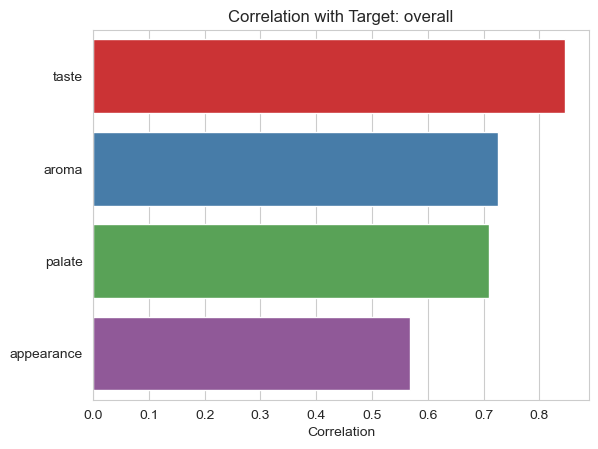

<Figure size 1200x800 with 0 Axes>

In [266]:
# Method 4 - Bar Chart: Seaborn
# Plot it with Seaborn just for fun
sns.barplot(data=factor_corr.sort_values('overall', ascending=False), y="index",x="overall")
plt.ylabel(""); plt.xlabel("Correlation")
plt.title("Correlation with Target: overall")
plt.figure(figsize=(12,8))
plt.show()